In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential

%load_ext tensorboard
import datetime



from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=3)

n_features = X.shape[1]
n_classes = Y.shape[1]

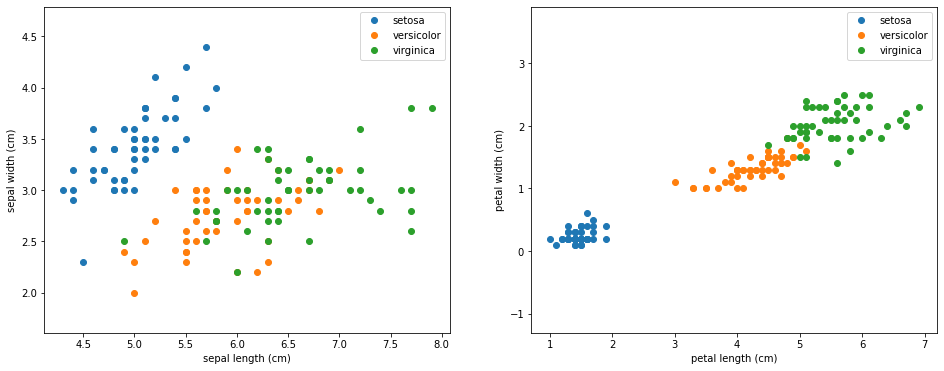

In [2]:
# Visualize the data sets
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();

plt.subplot(1, 2, 2)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend();

In [3]:
initializer0 = keras.initializers.RandomUniform(minval = -2, maxval =2)
initializer1 = keras.initializers.RandomUniform(minval = -2, maxval =2)
initializer2 = keras.initializers.RandomUniform(minval = -2, maxval =2)

class Diffact(keras.layers.Layer):
    def __init__(self):
        super(Diffact, self).__init__()
        self.k0 = self.add_weight(name='k0', shape = (), initializer=initializer0, trainable=True)
        self.k1 = self.add_weight(name='k1', shape = (), initializer=initializer1, trainable=True)
        self.k2 = self.add_weight(name='k2', shape = (), initializer=initializer2, trainable=True)
        
    def call(self, inputs):
        return self.k0 + tf.multiply(inputs, self.k1) + tf.multiply(tf.multiply(inputs,inputs), self.k2)

In [4]:
from keras import backend as K

class Mish(keras.layers.Layer):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X_input = Input(input_shape)
        >>> X = Mish()(X_input)
    '''

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

Using TensorFlow backend.


In [5]:
# create model with fully connected layers with dropout regulation
model = Sequential()
model.add(layers.Dense(25, input_dim=n_features, activation='relu'))
#diffact = Diffact()
#model.add(Mish())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(n_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                125       
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 78        
Total params: 203
Trainable params: 203
Non-trainable params: 0
_________________________________________________________________


In [6]:
batch_size = 5
epochs = 100

model.compile(loss="categorical_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

log_dir = "logs/fit11/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2 ,callbacks=[tensorboard_callback], verbose=1)


Epoch 1/100
 1/20 [>.............................] - ETA: 0s - loss: 1.1346 - accuracy: 0.2000WARNING:tensorflow:From C:\Users\shamb\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
20/20 [==============================] - 0s 10ms/step - loss: 1.0169 - accuracy: 0.4479 - val_loss: 0.8617 - val_accuracy: 0.7500
Epoch 2/100
20/20 [==============================] - 0s 1ms/step - loss: 0.8543 - accuracy: 0.5938 - val_loss: 0.7573 - val_accuracy: 0.8333
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 0.7675 - accuracy: 0.6458 - val_loss: 0.6831 - val_accuracy: 0.8750
Epoch 4/100
20/20 [==============================] - 0s 1ms/step - loss: 0.6548 - accuracy: 0.7396 - val_loss: 0.6182 - val_accuracy: 0.8750
Epoch 5/100
20/20 [==============================] - 0s 2ms/step - loss

Epoch 55/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1378 - accuracy: 0.9688 - val_loss: 0.2518 - val_accuracy: 0.9167
Epoch 56/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1348 - accuracy: 0.9583 - val_loss: 0.2456 - val_accuracy: 0.9167
Epoch 57/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1255 - accuracy: 0.9792 - val_loss: 0.2363 - val_accuracy: 0.9167
Epoch 58/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1427 - accuracy: 0.9479 - val_loss: 0.2311 - val_accuracy: 0.9167
Epoch 59/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1363 - accuracy: 0.9688 - val_loss: 0.2260 - val_accuracy: 0.9167
Epoch 60/100
20/20 [==============================] - 0s 1ms/step - loss: 0.1205 - accuracy: 0.9479 - val_loss: 0.2180 - val_accuracy: 0.9167
Epoch 61/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1206 - accuracy: 0.9583 - val_loss: 0.2191 - val_accuracy: 0.9167
Epoch 

In [7]:
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.0863376185297966
Test accuracy: 0.9666666388511658


In [8]:
#print("AF coefficients (weights) {}".format(diffact.get_weights()))

In [12]:
%tensorboard --logdir logs/fit11 --port=6038

Reusing TensorBoard on port 6038 (pid 6440), started 0:00:57 ago. (Use '!kill 6440' to kill it.)